# Disclaimer

If you are publishing data analysed by this software package please cite: DOI:10.5281/zenodo.1469364

Special thanks go to Duncan Johnstone, Elena Pascal, Paul R. Edwards and Jordi Ferrer-Orri in helping to create this particular analysis File

Code was shared by Armin Barthel to Edward Saunders for use in his Mini 2 NanoDTC project. Edward Saunders extended the code shared to this file.

In [1]:
#%matplotlib qt
import numpy as np
import matplotlib.pyplot as plt
import hyperspy.api as hs
import h5py
import os
from pathlib import Path
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar

In [2]:
%%capture 
# Just here to stop the output being spammed with progress bars for each correction.

In [3]:
%matplotlib qt

# Functions

In [4]:
def get_subfolders(folder):
    subfolders=[]
    _, sfnames,_ = next(os.walk(folder))
    for sfname in sfnames:
        subfolder=folder / sfname
        subfolders.append(subfolder)
    return subfolders

In [5]:
def CL_1D_signal(data_folder):
    file_to_open = data_folder / 'MicroscopeStatus.txt'
    
    """Get values from MicroscopeStatus"""
    
    with open(file_to_open, encoding='windows-1252' ) as status :
        for line in status:
            #if 'Field of view'  in line:
             #   calax = float(line[-9:-4] )    #calax= micro meter per pixel
            if 'Horizontal Binning' in line:
                binning = int(line[line.find(':')+1:-1])        #binning = binning status
            if 'Resolution_X' in line:
                nx = int(line[line.find(':')+1:-8])         #nx = pixel in x-direction
            if 'Resolution_Y' in line:
                ny = int(line[line.find(':')+1:-8])         #ny = pixel in y-direction
            if 'Real Magnification' in line:
                 FOV = float (line[line.find(':')+1:-2])
            if 'Grating - Groove Density:' in line:
                grating = float (line[line.find(':')+1:-7])
            if 'Camera Model:' in line:
                camera = str ((line[line.find(':')+1:-1]))
            if 'Central wavelength:' in line:
                centrelambda = float (line[line.find(':')+1:-3])
                
    
    if camera == 'A.920' :
        ch = 1024//binning
        Ebert = 21.2 # Ebert Angle in degree from Horiba website
        lccd = 26.7 # CCD width in mm from Andor Specsheet
        flength = 319.76001 #focal length in mm from horiba specsheet
        gamma = -3.5 #in degree
        lH = flength*np.cos(gamma/180*np.pi)
        hblcentre = flength*np.sin(gamma/180*np.pi)

        alpha = np.arcsin((10**(-6)*grating*centrelambda)/(2*np.cos((Ebert/(2*180))*np.pi)))/np.pi*180-Ebert/2 
        beta = Ebert+alpha

        betamin = beta + gamma - np.arctan((((lccd/ch)  * (ch - ch/2) + hblcentre)/lH))*180/np.pi
        lambdamin = ((np.sin(alpha/180*np.pi)+np.sin(betamin/180*np.pi))*10**6)/grating

        betamax = beta + gamma - np.arctan((((lccd/ch)  * (1 - ch/2) + hblcentre)/lH))*180/np.pi
        lambdamax = ((np.sin(alpha/180*np.pi)+np.sin(betamax/180*np.pi))*10**6)/grating

        if grating == 150 :
            corrfactor = 2.73E-04
        elif grating == 600 :
            corrfactor = 6.693659836087227e-05
        elif grating == 1200 :
            corrfactor = 3.7879942917985216e-05
        else :
            print('Something went wrong')
    
    elif camera =='A.(IR)490' :
        ch = 512//binning
        Ebert = -11.6348 # Ebert Angle in degree from Horiba website
        lccd = 12.8 # CCD width in mm from Andor Specsheet
        flength = 326.7 #focal length in mm from horiba specsheet
        gamma = -4.8088 #in degree
        lH = flength*np.cos(gamma/180*np.pi)
        hblcentre = flength*np.sin(gamma/180*np.pi)

        alpha = np.arcsin((10**(-6)*grating*centrelambda)/(2*np.cos((Ebert/(2*180))*np.pi)))/np.pi*180-Ebert/2 
        beta = Ebert+alpha

        betamin = beta + gamma - np.arctan((((lccd/ch)  * (ch - ch/2) + hblcentre)/lH))*180/np.pi
        lambdamin = ((np.sin(alpha/180*np.pi)+np.sin(betamin/180*np.pi))*10**6)/grating

        betamax = beta + gamma - np.arctan((((lccd/ch)  * (1 - ch/2) + hblcentre)/lH))*180/np.pi
        lambdamax = ((np.sin(alpha/180*np.pi)+np.sin(betamax/180*np.pi))*10**6)/grating

        if grating == 150 :
            corrfactor = 2.73E-04
        else :
            print('Something went wrong')
    
    
    else :
        print('Dont know that camera')
        
    """Load data into numpy array and make into hs object"""
        
    filename = data_folder / 'HYPCard.bin'
    with open(filename, 'rb') as f:    
        data = np.fromfile(f, dtype= [('bar', '<i4')], count= ch*nx*ny)
        #data = np.fromfile(f, count= 1024*nx*ny)
        array = np.reshape(data, [ch, nx, ny], order='F')

    sarray = np.swapaxes(array, 1,2) # Swap Axes for proper x-y use

    suncor = hs.signals.Signal2D(sarray).T
    suncor.change_dtype('float')
    
    """Define axes"""
    x = suncor.axes_manager.navigation_axes[0]
    y = suncor.axes_manager.navigation_axes[1]

    calax = 131072/(FOV*nx)

    x.name = 'x'
    x.scale = calax * 1000         #changes micrometer to nm, value for the size of 1 pixel
    x.units = 'nm'

    y.name = 'y'
    y.scale = calax * 1000      #changes micrometer to nm, value for the size of 1 pixel
    y.units = 'nm'

    dx = suncor.axes_manager.signal_axes[0]

    dx.name = 'wavelength'
    dx.scale = ((lambdamax-lambdamin)/ch)
    dx.offset = lambdamin
    dx.units = '$nm$'
    
    """Background correction""" # Needs background to be collected, doesn't automatically remove background from signal. Can do this fairly easily with PCA.
    background_filepath = data_folder / 'BKG1.txt'
    if os.path.exists(background_filepath):
        bkg = np.loadtxt(background_filepath, skiprows = 1)
        bkgarray =np.ones((nx,ny, len(bkg)))*bkg
        s = suncor - bkgarray
    else:
        s = suncor
        print("Spectra has no Background file")
        
    """Correction of wavelength shift along the x axis""" # necessary correction required, some detail associated with the grating
    garray=np.arange((-corrfactor/2) * calax * 1000 * (nx), (corrfactor/2) * calax * 1000 * (nx), corrfactor *calax * 1000) #(Total Variation, Channels, Step)
    barray = np.full((nx,ny),garray)
    s.shift1D(barray)
    
    return s, nx, ny

In [6]:
class CL_data:
    def __init__(self, data_folder):
        self.folder_path = data_folder
        
        
        f_name = str(data_folder) # should come up with something better later probably
        self.name = f_name[::-1][:f_name[::-1].index("\\")][::-1]
        
        s, nx, ny = CL_1D_signal(data_folder)  # warning can only plot after wavelength shift finished
        self.CL_map = s
        
        self.wavelengths = (np.arange(s.data.shape[2])*s.axes_manager[2].scale) + s.axes_manager[2].offset 
        
        self.pixel_size_x = s.axes_manager[0].scale
        self.pixel_size_y = s.axes_manager[1].scale
        
        try:
            Filename = "Live_Scan_"+str(nx)+"_"+str(ny)+"-SE.png"
            Live_SE_Filepath = data_folder / Filename
            SE = hs.load(Live_SE_Filepath)
            self.SE = SE
        except:
            self.SE = np.NaN
            
    def plot_over_SE(self):
        return self.CL_map.plot(navigator = self.SE, autoscale = "v")

# Extract Data

Will load all data in folder.

In [7]:
folder = Path("C:/Users/es758/OneDrive - University of Cambridge/NanoDTC/Mini 2/CL/edward-140322")
CL_data_list = [CL_data(data_folder) for data_folder in get_subfolders(folder)]
print("done")

Spectra has no Background file


  0%|          | 0/16384 [00:00<?, ?it/s]

Spectra has no Background file


  0%|          | 0/16384 [00:00<?, ?it/s]

Spectra has no Background file


  0%|          | 0/16384 [00:00<?, ?it/s]

Spectra has no Background file


  0%|          | 0/16384 [00:00<?, ?it/s]

Spectra has no Background file


  0%|          | 0/16384 [00:00<?, ?it/s]

Spectra has no Background file


  0%|          | 0/16384 [00:00<?, ?it/s]

Spectra has no Background file


  0%|          | 0/16384 [00:00<?, ?it/s]

Spectra has no Background file


  0%|          | 0/16384 [00:00<?, ?it/s]

Spectra has no Background file


  0%|          | 0/16384 [00:00<?, ?it/s]

Spectra has no Background file


  0%|          | 0/16384 [00:00<?, ?it/s]

Spectra has no Background file


  0%|          | 0/16384 [00:00<?, ?it/s]

done


# Data Analysis
Should probably in check that meta data is similar or normalisation if possible. For now just removing entries that are a bit different.

In [11]:
CL_data_list_comparable = CL_data_list.copy()
print(len(CL_data_list_comparable))
removed_list = []
for sample in CL_data_list_comparable:
    if sample.name == "HYP-500NMHVNE-3KV-10NA-30NM-1":
        removed_list.append(sample)
    elif sample.name == "HYP-500NMHVNE-3KV-10NA-30NM-390NM-G600-1":
        removed_list.append(sample)
    elif sample.name == "HYP-500NMHVNE-3KV-10NA-30NM-500NM-2-Z46":
        removed_list.append(sample)    
    elif sample.name ==  "HYP-T0-3KV-10NA-25NM-1":
        removed_list.append(sample)
    elif sample.name ==  "HYP-T0-3KV-10NA-25NM-2":
        removed_list.append(sample)
for sample in removed_list:
    CL_data_list_comparable.remove(sample)
print(len(CL_data_list_comparable))

11
6


In [12]:
for scan in CL_data_list_comparable:
    print(scan.name)

HYP-500NMHVHE-3KV-10NA-30NM-500NM-1
HYP-500NMHVHE-3KV-10NA-30NM-500NM-2
HYP-500NMHVLE-3KV-10NA-30NM-500NM-1
HYP-500NMHVLE-3KV-10NA-30NM-500NM-2
HYP-500NMHVNE-3KV-10NA-30NM-500NM
HYP-500NMHVNE-3KV-10NA-30NM-500NM-3


In [77]:
CL_data_list_comparable[2].CL_map.T.plot(navigator="auto")

In [75]:
CL_data_list[-1].CL_map.T.plot()

Compare point by point?

In [76]:
CL_data_list_comparable[0].CL_map.plot(navigator="auto")

In [71]:
CL_data_list_comparable[2].CL_map.plot(navigator="auto")

Traceback (most recent call last):
  File "C:\Users\es758\anaconda3\envs\mini2_GaN\lib\site-packages\matplotlib\cbook\__init__.py", line 270, in process
    func(*args, **kwargs)
  File "C:\Users\es758\anaconda3\envs\mini2_GaN\lib\site-packages\hyperspy\drawing\image.py", line 619, in on_key_press
    self.gui_adjust_contrast()
  File "C:\Users\es758\anaconda3\envs\mini2_GaN\lib\site-packages\hyperspy\drawing\image.py", line 591, in gui_adjust_contrast
    return ceditor.gui(display=display, toolkit=toolkit)
  File "C:\Users\es758\anaconda3\envs\mini2_GaN\lib\site-packages\hyperspy\ui_registry.py", line 163, in pg
    return get_gui(self, toolkey=toolkey, display=display,
  File "C:\Users\es758\anaconda3\envs\mini2_GaN\lib\site-packages\hyperspy\ui_registry.py", line 132, in get_gui
    importlib.import_module(
  File "C:\Users\es758\anaconda3\envs\mini2_GaN\lib\importlib\__init__.py", line 127, in import_module
    return _bootstrap._gcd_import(name[level:], package, level)
  File "<f

In [ ]:
CL_data_list_comparable[4].CL_map.plot(navigator="auto")

## Mean Spectra

In [66]:
plt.figure("normalised")
mean_list = []
for sample in CL_data_list_comparable:    
    mean = sample.CL_map.mean((0,1))
    
    # dodgy background removal
    mean -= np.mean(mean.data[:50])
    
    # append to list for later use
    mean_list.append(mean)
    
    # normalise by main peak height
    normalised_mean = mean.data[:].copy()/np.max(mean.data[:])
    
    plt.plot(sample.wavelengths, normalised_mean, label = sample.name)
plt.xlabel("Wavelength (nm)")
plt.ylabel("Normalised Intensity")
plt.legend()
plt.show()  

plt.figure("absolute")
mean_list = []
for sample in CL_data_list_comparable:    
    mean = sample.CL_map.mean((0,1))
    
    # dodgy background removal
    mean -= np.mean(mean.data[:50])
    
    # append to list for later use
    mean_list.append(mean)
    
    plt.plot(sample.wavelengths, mean, label = sample.name)
plt.xlabel("Wavelength (nm)")
plt.ylabel("Intensity")
plt.legend()
plt.show()  

Just plotting wider FOV hoping it is less spatially dependent 

In [81]:
index=[0,3,5]

plt.figure("normalised")
mean_list = []
for sample in CL_data_list_comparable:
    if CL_data_list_comparable.index(sample) in index:
        pass
    else:
        mean = sample.CL_map.mean((0,1))

        # dodgy background removal
        mean -= np.mean(mean.data[:50])

        # append to list for later use
        mean_list.append(mean)

        # normalise by main peak height
        normalised_mean = mean.data[:].copy()/np.max(mean.data[:])

        plt.plot(sample.wavelengths, normalised_mean, label = sample.name)
plt.xlabel("Wavelength (nm)")
plt.ylabel("Normalised Intensity")
plt.legend()
plt.show()  

plt.figure("absolute")
mean_list = []
for sample in CL_data_list_comparable:
    if CL_data_list_comparable.index(sample) in index:
        pass
    else:
        mean = sample.CL_map.mean((0,1))

        # dodgy background removal
        mean -= np.mean(mean.data[:50])

        # append to list for later use
        mean_list.append(mean)

        plt.plot(sample.wavelengths, mean, label = sample.name)
plt.xlabel("Wavelength (nm)")
plt.ylabel("Intensity")
plt.legend()
plt.show() 

## Panchromatic Images

In [28]:
panchrom_list = []
names = []
scale_list = []
for sample in CL_data_list_comparable:
    scale_list.append(sample.pixel_size_x)
    panchrom = sample.CL_map.mean((2)).data
    panchrom_list.append(panchrom)
    names.append(sample.name)

In [80]:
# should try plot these with scale bar to compare size from dislocation. Maybe just do that for PCA, but could be worked in here.
biggest0 = 0
current_biggest_index = 0
for pchromim in panchrom_list:
    biggest1 = np.max(pchromim)
    if biggest1>biggest0:
        biggest0 = biggest1
        biggest_index = current_biggest_index
    current_biggest_index += 1
#     print(biggest1)
# print(biggest0)
# print(biggest_index)

fig, axs = plt.subplots(nrows=3, ncols=2)
for i in np.arange(3):
    index_temp = i*2
    for j in np.arange(2):
        im = axs[i,j].imshow(panchrom_list[index_temp], cmap='Greys_r')#, vmin=0, vmax=biggest0)
        axs[i,j].set_title(label=names[index_temp], fontsize =5)
        
        sb_len = 40 # for now this seems to be pixels
        
        scalebar = AnchoredSizeBar(axs[0,0].transData,
                           sb_len, f'{round(sb_len*scale_list[index_temp])} nm', 'lower center', 
                           pad=0.1,
                           color='red',
                           frameon=False,
                           size_vertical=1)
        
        axs[i,j].add_artist(scalebar)
        
        
        index_temp += 1
        if i == biggest_index:
            legend_map = im
        
        axs[i, j].axis("off")
    #
fig.subplots_adjust(wspace=0, hspace=0.2) # imshow increases width with padding unless specify size so can't get flush

#fig.subplots_adjust(right=0.8)
# cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
# fig.colorbar(legend_map, cax=cbar_ax)

## Attempt to look at dislocations

In [79]:
%matplotlib qt

def plot_at_fov(CL_data_object, scale=4000): # scale in nm
    x_pixels = CL_data_object.CL_map.data.shape[0]
    crop_size = scale/(CL_data_object.pixel_size_x)
    
    if crop_size > x_pixels:
        print("no crop")
    
    lower_ind = round((x_pixels-crop_size)/2)
    higher_ind = round((x_pixels+crop_size)/2)
    # print(lower_ind)
    # print(higher_ind)
    
    return CL_data_object.CL_map.data[lower_ind:higher_ind,lower_ind:higher_ind,:]

i=0
for sample in CL_data_list_comparable:
    if i in [1,2,4]:
        #sample.CL_map.T.plot(navigator="slider")
        plt.figure(sample.name+" normalised fixed wavelength image")
        
        ### AM CHOOSING WHICH WAVELENGTH TO LOOK AT BY INDEX HERE
        
        im=plot_at_fov(sample)[:,:,290] 
        
        plt.imshow(im/np.max(im),vmax=0.8, extent=[0,im.shape[0]*sample.pixel_size_x,0,im.shape[0]*sample.pixel_size_x])
        plt.xlabel("x (nm)")
        plt.ylabel("y (nm)")
    i+=1
plt.show()

## Bandpasses

Swap axes to navigate on the wavelength axis

In [43]:
im = CL_data_list_comparable[2].CL_map.T
im.plot()

In [ ]:
roi1 = hs.roi.SpanROI(left=300, right=400)      #sets a digitalbandfilter
im_roi1 = roi1.interactive(im, color="red")
roi2 = hs.roi.SpanROI(left=400, right=500)      #sets another digitalbandfilter
im_roi2 = roi2.interactive(im, color="blue")
roi3 = hs.roi.SpanROI(left=500, right=600)      #sets another digitalbandfilter
im_roi3 = roi3.interactive(im, color="green")

In [64]:
sample.CL_map.metadata

├── General
│   └── title = 
└── Signal
    ├── binned = False
    └── signal_type =

Selected Bandpasses with Image as Navigator

In [44]:
roi1(im).T.plot( navigator_kwds=dict(colorbar=True,
                             scalebar_color='black',
                             cmap='Reds_r'))

roi2(im).T.plot( navigator_kwds=dict(colorbar=True,
                             scalebar_color='black',
                             cmap='Blues_r'))

roi3(im).T.plot( navigator_kwds=dict(colorbar=True,
                            scalebar_color='black',
                            cmap='Greens_r'))

Take a linescan through map

In [22]:
line = hs.roi.Line2DROI(x1=346.018, y1=1435.37, x2=1747.57, y2=1324.84, linewidth=50)
s.plot()
line.add_widget(s)

In [24]:
trace  = line(s).T.sum(0)
trace.plot()

Take a Linespectrum through the Map

In [20]:
line = hs.roi.Line2DROI(x1=346.018, y1=1435.37, x2=1747.57, y2=1324.84, linewidth=100)
s.plot()
line.add_widget(s)

In [21]:
spectrace  = line(s)
spectrace.plot( navigator_kwds=dict(colorbar=True,
                             scalebar_color='red',
                             cmap='inferno_r',
                             aspect = 0.1))

# Unsupervised ML

PCA decomposition - Takes lot of Processing Power/Takes a lot of time

In [7]:
def remove_background_bodge(s_object):
    s = s_object.CL_map
    # br = s.remove_background(signal_range = (s_object.wavelengths[0],300), background_type="Offset")
    br = s.copy()
    for x in br.data:
        for y in x:
            y -= np.min(y)
    return br

def approx_X(X, Num_keep_comps = 100):
    A_all = X.get_decomposition_factors()
    B_all = X.get_decomposition_loadings()
    for i in np.arange(Num_keep_comps):
        A = A_all.inav[i]
        B = B_all.inav[i]
        if i == 0:
            X_approx=A*(B.T)
        else:
            X_approx+=A*(B.T)
    
    # sometimes get negative values from approx so will for now boost by min
    #X_approx += np.min(X_approx.data)
    for x in X_approx.data:
        for y in x:
            y -= np.min(y)
    
    return X_approx

In [8]:
def plot_scree(X, crop = -1):
    plt.figure("Scree", dpi = 200)
    plt.plot(X.get_explained_variance_ratio().data[:crop], marker = '.', markersize=5, linestyle="None")
    plt.yscale("log")
    plt.xlabel("Principal Component Index", fontsize=10)
    plt.ylabel("Proportion of Variance", fontsize=10)
    plt.show()

def plot_decomposition_factors(s_object, br, N):
    plt.figure("Decomposition Factors", dpi=200)
    for i in np.arange(N):
        plt.plot(s_object.wavelengths, br.get_decomposition_factors().data[i], marker = 'None', markersize=10, label=i, linewidth= 1)
    plt.legend(fontsize=10)
    plt.xlabel("Wavelength ($nm$)", fontsize=10)
    plt.ylabel("Intensity", fontsize=10)
    plt.show()
    
def plot_loadings(s, N, same_map=True, log = False):

    biggest0 = 0
    smallest0 = np.max(s.get_decomposition_loadings().data[0])
    for i in np.arange(N):
        biggest1 = np.max(s.get_decomposition_loadings().data[i])
        smallest1 = np.min(s.get_decomposition_loadings().data[i])
        if biggest1>biggest0:
            biggest0 = biggest1
            biggest_index = i
        if smallest1<smallest0:
            smallest0 = smallest1
            smallest_index = i

    fig, axs = plt.subplots(nrows=1, ncols=N)
    
    if same_map == True:
        for i in np.arange(N):
            im = axs[i].imshow(s.get_decomposition_loadings().data[i], cmap='viridis', vmin=smallest0, vmax=biggest0)
            if log == True:
                im = axs[i].imshow(np.log(s.get_decomposition_loadings().data[i]), cmap='viridis', vmin=smallest0, vmax=biggest0)
            if i == biggest_index:
                im1=im
            axs[i].axis("off")
            axs[i].title.set_text(i)
        fig.subplots_adjust(right=0.8)
        cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
        fig.colorbar(im1, cax=cbar_ax)
    elif same_map == False:
        for i in np.arange(N):
            im = axs[i].imshow(np.log(s.get_decomposition_loadings().data[i]), cmap='viridis')
            if log == True:
                im = axs[i].imshow(np.log(s.get_decomposition_loadings().data[i]), cmap='viridis')
            axs[i].axis("off")
            axs[i].title.set_text(i)

In [38]:
folder = Path("C:/Users/es758/OneDrive - University of Cambridge/NanoDTC/Mini 2/CL/edward-140322")
#folder = Path("C:/Users/es758/OneDrive - University of Cambridge/NanoDTC/Mini 2/CL/edward-300322/CL Maps")
data_folder = get_subfolders(folder)[2]
print(data_folder)

C:\Users\es758\OneDrive - University of Cambridge\NanoDTC\Mini 2\CL\edward-140322\HYP-500NMHVLE-3KV-10NA-30NM-500NM-1


In [39]:
s_object = CL_data(data_folder)

Spectra has no Background file


  0%|          | 0/16384 [00:00<?, ?it/s]

In [40]:
%matplotlib qt
s_object.CL_map.plot(autoscale="")

Perform initial decomposition and inspect Scree plot

Decomposition info:
  normalize_poissonian_noise=False
  algorithm=SVD
  output_dimension=None
  centre=None


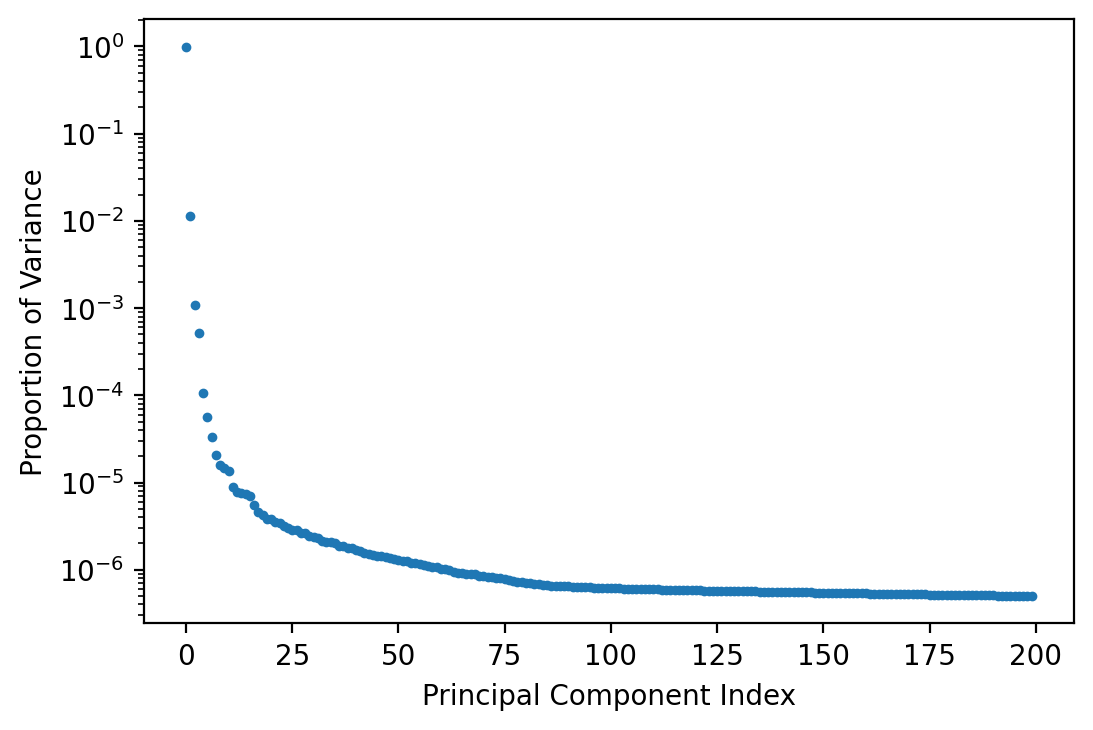

In [51]:
%matplotlib inline
br = remove_background_bodge(s_object)
br.decomposition()
plot_scree(br, crop = 200)

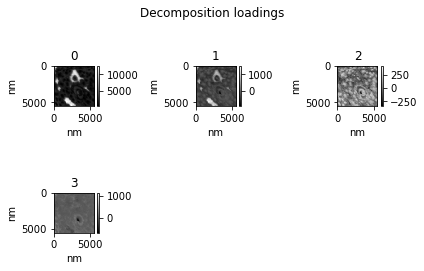

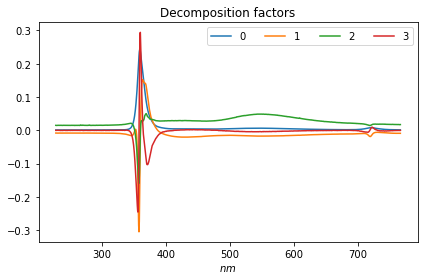

In [52]:
%matplotlib inline

N=4

br.plot_decomposition_loadings(comp_ids=N) # look at relevant sections of the image
br.plot_decomposition_factors(comp_ids=N) # look at corresponding spectra
plt.show()

Attempt NMF

In [53]:
N=4

In [54]:
br.decomposition(algorithm="NMF", output_dimension=N)

C:\Users\es758\anaconda3\envs\mini2_GaN\lib\site-packages\sklearn\decomposition\_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(
C:\Users\es758\anaconda3\envs\mini2_GaN\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Decomposition info:
  normalize_poissonian_noise=False
  algorithm=NMF
  output_dimension=4
  centre=None
scikit-learn estimator:
NMF(n_components=4)


In [55]:
%matplotlib qt
plot_decomposition_factors(s_object, br, N)
plot_loadings(br, N, same_map=False, log = False)

C:\Users\es758\AppData\Local\Temp/ipykernel_16528/2097464459.py:48: RuntimeWarning: divide by zero encountered in log
  im = axs[i].imshow(np.log(s.get_decomposition_loadings().data[i]), cmap='viridis')


Do decomposition and reduce down data for further decomposition

In [46]:
br.decomposition()
X_approx = approx_X(br, 25)

Decomposition info:
  normalize_poissonian_noise=False
  algorithm=SVD
  output_dimension=None
  centre=None


In [47]:
X_approx.decomposition()
plot_scree(X_approx, 10)

Decomposition info:
  normalize_poissonian_noise=False
  algorithm=SVD
  output_dimension=None
  centre=None


Attempt NMF again and see if it is better

In [48]:
N = 3

In [49]:
X_approx.decomposition(algorithm="NMF", output_dimension=N)

C:\Users\es758\anaconda3\envs\mini2_GaN\lib\site-packages\sklearn\decomposition\_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


Decomposition info:
  normalize_poissonian_noise=False
  algorithm=NMF
  output_dimension=3
  centre=None
scikit-learn estimator:
NMF(n_components=3)


C:\Users\es758\anaconda3\envs\mini2_GaN\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


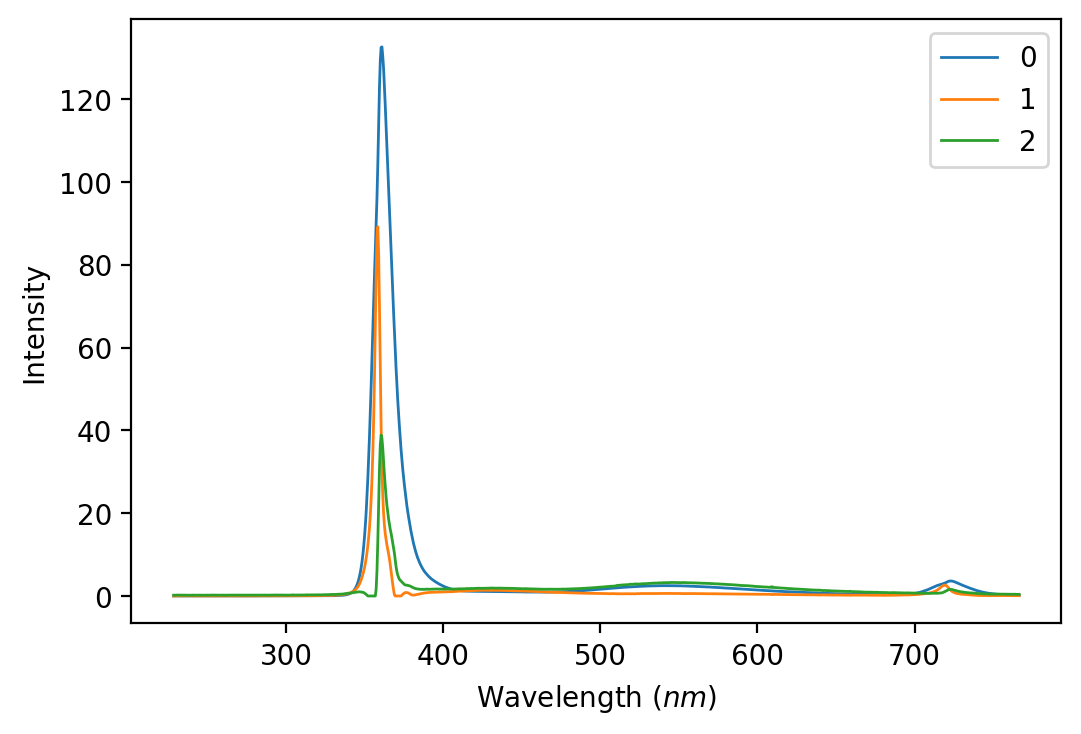

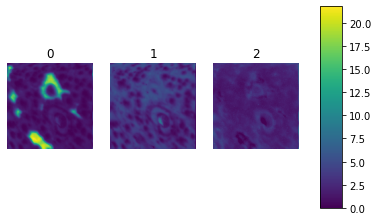

In [50]:
%matplotlib inline
plot_decomposition_factors(s_object, X_approx, N)
plot_loadings(X_approx, N, same_map=True, log = False)

Attempt BSS

Decomposition info:
  normalize_poissonian_noise=False
  algorithm=SVD
  output_dimension=None
  centre=None


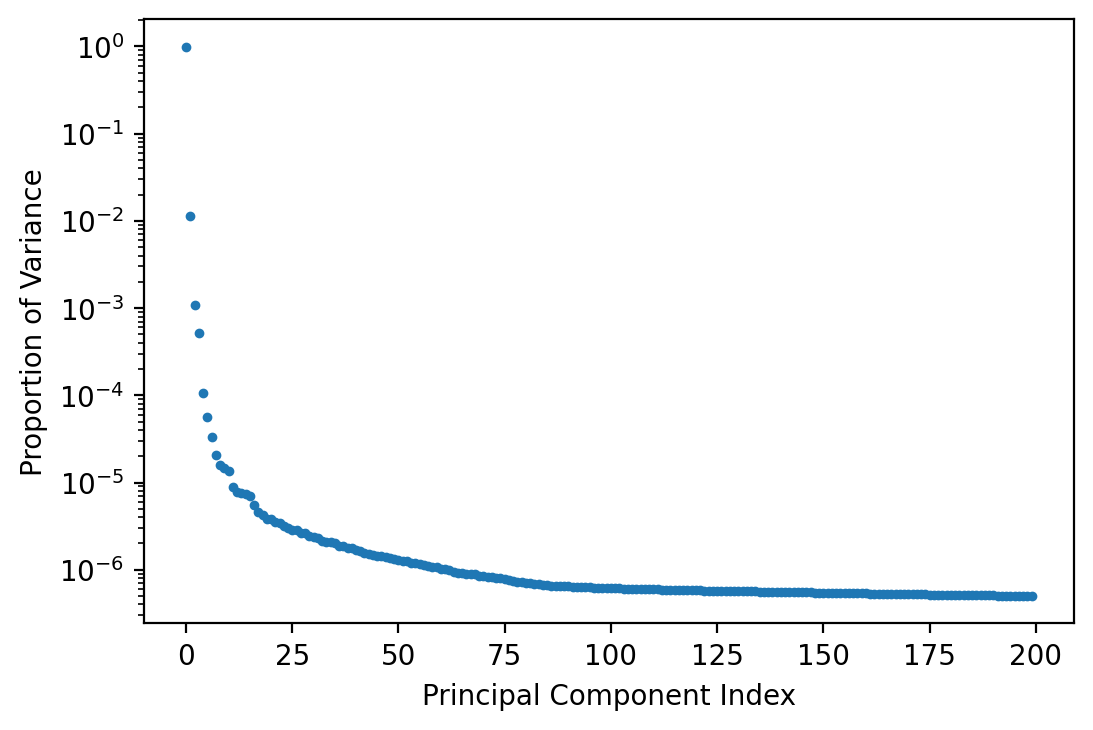

In [151]:
%matplotlib inline
br = remove_background_bodge(s_object)
br.decomposition()
plot_scree(br, crop = 200)

In [159]:
N = 4
br.blind_source_separation(number_of_components=N)

[########################################] | 100% Completed |  0.1s


Blind source separation info:
  number_of_components=4
  algorithm=sklearn_fastica
  diff_order=1
  reverse_component_criterion=factors
  whiten_method=PCA
scikit-learn estimator:
FastICA(tol=1e-10, whiten=False)


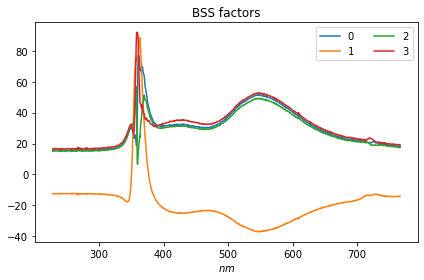

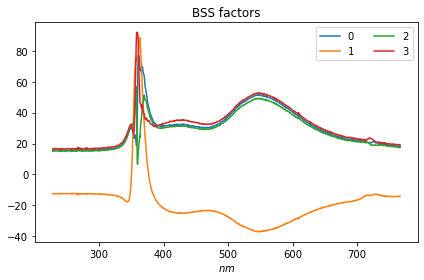

In [160]:
br.plot_bss_factors()
br.plot_bss_factors()
plt.show()

In [123]:
### Leftovers from trying to do with sklearn 

# hyperim = s_object.CL_map.data
# hyperim.shape

# from sklearn import decomposition
# model = decomposition.NMF(n_components=3)
# W = model.fit_transform(hyperim)
# H = model.components_

## Gaussian fitting example

In [22]:
m = s.create_model()   #Creates a Model for fitting

In [23]:
g1 = hs.model.components1D.Expression(
expression="height * exp(-(x - x0) ** 2 * 4 * log(2)/ fwhm ** 2)",
name="Groundstate",
position="x0",
height=1,
fwhm=1,
x0=0,
module="numpy")

g2 = hs.model.components1D.Expression(
expression="height * exp(-(x - x0) ** 2 * 4 * log(2)/ fwhm ** 2)",
name="First Excited State",
position="x0",
height=1,
fwhm=1,
x0=0,
module="numpy")

g3 = hs.model.components1D.Expression(
expression="height * exp(-(x - x0) ** 2 * 4 * log(2)/ fwhm ** 2)",
name="Second excited State",
position="x0",
height=1,
fwhm=1,
x0=0,
module="numpy")

bkg = hs.model.components1D.Offset()   # sets background

In [24]:
m.extend([g1,g2, g3, bkg])                    #adds fits and bkg to the model

In [25]:
m.components                        #shows components of the model

   # |      Attribute Name |      Component Name |      Component Type
---- | ------------------- | ------------------- | -------------------
   0 |         Groundstate |         Groundstate |          Expression
   1 | First_Excited_State | First Excited State |          Expression
   2 | Second_excited_St.. | Second excited St.. |          Expression
   3 |              Offset |              Offset |              Offset

Sets first values for Fit

In [38]:
g1.x0.value = 1153   # Guess for centre wavelength
g1.x0.bmax = 1160     # Max value for centre wavelength
g1.x0.bmin = 1120     # Min value for centre wavelength

g1.fwhm.value = 50      #Guess for FWHM
g1.fwhm.bmax = 100       #Maxvalue for FWHM
g1.fwhm.bmin = 25       #Minvalue for FWHM

g1.height.value = 500       #Guess for peak Intensity
g1.height.bmax = 4000      #Maxvalue for peak Intesity
g1.height.bmin = 1         #Minvalue for peak Intensity

g2.x0.value = 1080   # Guess for centre wavelength
g2.x0.bmax = 1090     # Max value for centre wavelength
g2.x0.bmin = 1050     # Min value for centre wavelength

g2.fwhm.value = 50      #Guess for FWHM
g2.fwhm.bmax = 75       #Maxvalue for FWHM
g2.fwhm.bmin = 25       #Minvalue for FWHM

g2.height.value = 500       #Guess for peak Intensity
g2.height.bmax = 1500      #Maxvalue for peak Intesity
g2.height.bmin = 1         #Minvalue for peak Intensity

g3.x0.value = 1030  # Guess for centre wavelength
g3.x0.bmax = 1040     # Max value for centre wavelength
g3.x0.bmin = 1015     # Min value for centre wavelength

g3.fwhm.value = 50      #Guess for FWHM
g3.fwhm.bmax = 75       #Maxvalue for FWHM
g3.fwhm.bmin = 25       #Minvalue for FWHM

g3.height.value = 500       #Guess for peak Intensity
g3.height.bmax = 1500      #Maxvalue for peak Intesity
g3.height.bmin = 1         #Minvalue for peak Intensity


bkg.offset.value = 5  #Background to be substracted

In [39]:
s.plot()                #plots map
m.plot(plot_components=True)              # adds fit model to map
#m.gui()

In [40]:
m.fit(bounded=True)         #fits function in selected point to measured curve
m.print_current_values()    #Prints values of fit in the set pixel

Parameter Name,Free,Value,Std,Min,Max
fwhm,True,38.0112,0.269118,25,100
height,True,2435.04,13.1647,1,4000
x0,True,1153.88,0.096883,1120,1160
Parameter Name,Free,Value,Std,Min,Max
fwhm,True,40.292,0.613254,25,75
height,True,1304.43,13.9475,1,1500
x0,True,1088.09,0.214471,1050,1090
Parameter Name,Free,Value,Std,Min,Max
fwhm,True,34.2249,1.59749,25,75
height,True,429.304,13.6834,1,1500


In [27]:
m.plot()

Traceback (most recent call last):
  File "C:\Users\Gunnar\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py", line 224, in process
    func(*args, **kwargs)
  File "C:\Users\Gunnar\anaconda3\lib\site-packages\hyperspy\drawing\image.py", line 615, in on_key_press
    self.gui_adjust_contrast()
  File "C:\Users\Gunnar\anaconda3\lib\site-packages\hyperspy\drawing\image.py", line 586, in gui_adjust_contrast
    ceditor = ImageContrastEditor(self)
  File "C:\Users\Gunnar\anaconda3\lib\site-packages\hyperspy\signal_tools.py", line 795, in __init__
    self.image._vmin_percentile.split('th')[0])
AttributeError: 'float' object has no attribute 'split'


In [ ]:
m.multifit(bounded=True, iterpath='serpentine')    #fits to the whole map

Plots Centre Wavelength of Fit g1

In [55]:
g1.x0.plot(colorbar=True,                             
                             cmap='Spectral_r',
                             centre_colormap = False,
                             saturated_pixels=0)

g2.x0.plot(colorbar=True,                             
                             cmap='Spectral_r',
                             centre_colormap = False,
                             saturated_pixels=0)

g3.x0.plot(colorbar=True,                             
                             cmap='Spectral_r',
                             centre_colormap = False,
                             saturated_pixels=0)


Added statistical Analysis written by Giorgio Divitini

In [ ]:
wavelength = g1.x0.as_signal()
wavelength.data.mean()
wavelength.data.std()

Plots peak intensity of Fit g1

In [57]:
g1.height.plot(colorbar=True,                             
                             cmap='viridis',
                             centre_colormap = False,
                             saturated_pixels=0)

g2.height.plot(colorbar=True,                             
                             cmap='viridis',
                             centre_colormap = False,
                             saturated_pixels=0)

g3.height.plot(colorbar=True,                             
                             cmap='viridis',
                             centre_colormap = False,
                             saturated_pixels=0)


Plots FWHM of Fit g1

In [29]:
g1.fwhm.plot(colorbar=True,                             
                             cmap='magma',
                             centre_colormap = False,
                             saturated_pixels=0)

g2.fwhm.plot(colorbar=True,                             
                             cmap='magma',
                             centre_colormap = False,
                             saturated_pixels=0)

g3.fwhm.plot(colorbar=True,                             
                             cmap='magma',
                             centre_colormap = False,
                             saturated_pixels=0)


Extract and save a spectrum from a pixel

In [ ]:
s.plot() #Plot Map, move cursor to desired pixel

In [ ]:
Px , Py = s.axes_manager.indices  #reads in cursor positions
yvals = s.inav[Px, Py]            # gets y-axis at cursor position
xvals = dx.offset+np.arange(len(yvals.data))*(dx.scale*binning) #creates a wavelength-axis to save

Saves the point as hdf5 (Origin readable)

In [ ]:
hf = h5py.File('C:\\Filepath\\Filename.h5', 'w') #replace w with r+ if saving multiple points into the same file
h1 = hf.create_group('Point1')
h1.create_dataset('Wavelength-Axis', data=xvals)
h1.create_dataset('Intensity', data= yvals)
hf.close()